# Non-Linear Least Squares Fitting with Python  
For tasks requiring even the slightest amount of sophistication, the use of options like MS Excel becomes unrealistic. At this point, tools like MATLAB, Mathematica, or OriginLab must be employed.  

An increasingly popular option within the sciences is the use of the Python programming language, particularly within the [Jupyter Notebook](http://jupyter.org/) environment, due to the very powerful methods of manipulation and inspection made available through an array of open source packages. In particular, and for our use here, the [Numpy](http://www.numpy.org/) (matrix manipulation), [Scipy](https://www.scipy.org/) (scientific/engineering algorithms), and [Matplotlib](https://matplotlib.org/) (advanced plotting) packages offer a robust suite of analysis tools.  

Non-linear least squares fitting in Python can easily be achieved with either of two options: 
+ the [`curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
+ the [LMFIT](https://lmfit.github.io/lmfit-py/) package, which is a powerful extension of scipy.optimize 

Examples using both are demonstrated below.

# Fitting in 1D

In [1]:
# package imports 
from math import *
import numpy as np
from scipy.optimize import curve_fit
from lmfit import Model

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = '#e8e8e8'
plt.rcParams['axes.edgecolor'] = '#e8e8e8'
plt.rcParams['figure.facecolor'] = '#e8e8e8'

The data to be considered will be a simple Gaussian distribution of amplitude, $A$, centered at $x_c$, and standard distribution, $\sigma$:  
### $$ f(x) = \frac{A}{\sqrt{2\pi\sigma^2}} e^{-\big[\frac{(x-x_c)^2}{2\sigma^2}\big]} $$

In [2]:
# define some function to play with
def gaussian(x, amp, xc, sigma):
    return amp*np.exp( -(x-xc)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

# set initial parameters for fit function
x = np.arange(256)
amp = 1
xc = np.median(x)
sigma = x[-1]/10
noise_factor = 0.05

# make both clean and noisy data
data = gaussian(x, amp, xc, sigma)
noise = data + noise_factor*data.max()*np.random.normal(size=data.shape)

## Method 1: using the `scipy.optimize` package  
The scipy package is easy to use and performs very well, but only returns limited information. Most of the time, though, it's exactly what you want: the fit values and covariance matrix. The diagonal elements of the covariance matrix equal the variance of each fit parameter, which can be used to calculate the fit parameter uncertainties, $\sigma_{ii}$.

\begin{equation*}
   Cov = \mathbf{\sigma}^2_{i,j} = 
    \begin{pmatrix} 
        \sigma^2_{1} & \sigma_{1}\sigma_{2} & \sigma_{1}\sigma_{3} \\ 
        \sigma_{2}\sigma_{1} & \sigma^2_{2} & \sigma_{2}\sigma_{3} \\ 
        \sigma_{3}\sigma_{1} & \sigma_{3}\sigma_{2} & \sigma^2_{3} 
    \end{pmatrix}
\end{equation*}

Unfortunately, any goodness of fit ($R^2$, $\chi ^2$, etc.) is not returned, but it can easily be calculated:  

$$R^2 = 1 - \frac{\text{(variance of residual)}}{\text{(total variance)}}$$

In [3]:
# define some initial guess values for the fit routine
guess_vals = [amp*2, xc*0.8, sigma/1.5]

# perform the fit and calculate fit parameter errors from covariance matrix
fit_params, cov_mat = curve_fit(gaussian, x, noise, p0=guess_vals)
fit_errors = np.sqrt(np.diag(cov_mat))

# manually calculate R-squared goodness of fit
fit_residual = noise - gaussian(x, *fit_params)
fit_Rsquared = 1 - np.var(fit_residual)/np.var(noise)

print('Fit R-squared:', fit_Rsquared, '\n')
print('Fit Amplitude:', fit_params[0], '\u00b1', fit_errors[0])
print('Fit Center:   ', fit_params[1], '\u00b1', fit_errors[1])
print('Fit Sigma:    ', fit_params[2], '\u00b1', fit_errors[2])

Fit R-squared: 0.97982807133 

Fit Amplitude: 0.988386114814 ± 0.00878700277247
Fit Center:    127.76116133 ± 0.260923324556
Fit Sigma:     25.4172957823 ± 0.260923330052


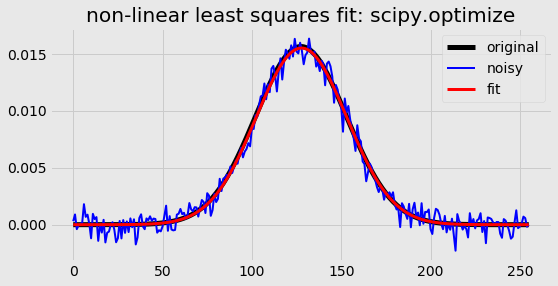

In [4]:
# plotting shizzle 
plt.figure(figsize=(8,4))

plt.plot(x, data, linewidth=5, color='k', label='original')
plt.plot(x, noise, linewidth=2, color='b', label='noisy')
plt.plot(x, gaussian(x, *fit_params), linewidth=3, color='r', label='fit')

plt.title('non-linear least squares fit: scipy.optimize')
plt.legend()
plt.show()

## Method 2: using the [LMFIT](https://lmfit.github.io/lmfit-py/model.html) package  

Under the hood, the LMFIT package actually uses `scipy.optimize`, but adds more advanced functionality for fit options and gives immediate access to fit perfomance and data statistics (see below). Although $\chi^2$ and the $\text{reduced-}\chi^2$ are automatically calculated, $R^2$ is not. Again, it's a trivial matter to calculate it. 

In [5]:
# tell LMFIT what fn you want to fit, then fit, starting iteration with guess values
lmfit_model = Model(gaussian)
lmfit_result = lmfit_model.fit(noise, x=x, 
                               amp=guess_vals[0], 
                               xc=guess_vals[1], 
                               sigma=guess_vals[2])

# again, calculate R-squared
lmfit_Rsquared = 1 - lmfit_result.residual.var()/np.var(noise)

print('Fit R-squared:', lmfit_Rsquared, '\n')
print(lmfit_result.fit_report())

Fit R-squared: 0.979828071209 

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 256
    # variables        = 3
    chi-square         = 1.4454e-04
    reduced chi-square = 5.7129e-07
    Akaike info crit   = -3677.11260
    Bayesian info crit = -3666.47707
[[Variables]]
    amp:    0.98838627 +/- 0.00878703 (0.89%) (init = 2)
    xc:     127.761160 +/- 0.26092548 (0.20%) (init = 102)
    sigma:  25.4173037 +/- 0.26092548 (1.03%) (init = 17)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma) =  0.577



In [6]:
# another view of fit parameters
lmfit_result.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp      0.9884     -inf      inf 0.008787     True     None     None
sigma     25.42     -inf      inf   0.2609     True     None     None
xc        127.8     -inf      inf   0.2609     True     None     None


You might notice here that the parameters can have several conditions placed on them in order to constrain the fit routine, such as: min and max bounds, ability to fix a value, or forcing a parameter to adhere to an analytic expression. Use of these is covered in the LMFIT documentation.

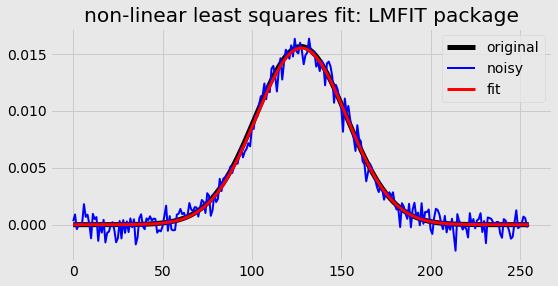

In [7]:
# plotting shizzle 
plt.figure(figsize=(8,4))

plt.plot(x, data, linewidth=5, color='k', label='original')
plt.plot(x, noise, linewidth=2, color='b', label='noisy')
plt.plot(x, lmfit_result.best_fit, linewidth=3, color='r', label='fit')

plt.title('non-linear least squares fit: LMFIT package')
plt.legend()
plt.show()

In [8]:
# report best fit parameters with 1*sigma, 2*sigma, and 3*sigma confidence interrvals
print(lmfit_result.ci_report())

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 amp  :  -0.02657  -0.01767  -0.00882   0.98839  +0.00884  +0.01777  +0.02682
 xc   :  -0.79145  -0.52490  -0.26054 127.76116  +0.26051  +0.52479  +0.79120
 sigma:  -0.78497  -0.52303  -0.26227  25.41730  +0.26504  +0.53471  +0.81020


In [9]:
# show goodness of fits, X^2 and the reduced-X^2
print('Fit X^2:        ', lmfit_result.chisqr)
print('Fit reduced-X^2:', lmfit_result.redchi)

Fit X^2:         0.000144536113249
Fit reduced-X^2: 5.71288985172e-07


In [10]:
# access info on data set and fit performance
print('Number of Data Points:', lmfit_result.ndata)
print('Number of Fit Iterations:', lmfit_result.nfev)
print('Number of freely independent variables:', lmfit_result.nvarys)
print('Did the fit converge?:', lmfit_result.success)

Number of Data Points: 256
Number of Fit Iterations: 25
Number of freely independent variables: 3
Did the fit converge?: True


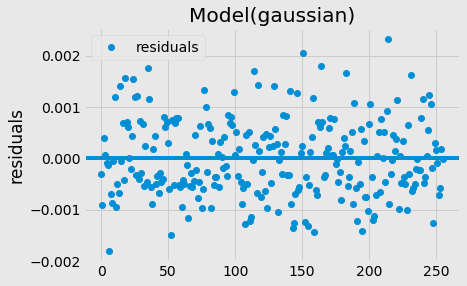

In [11]:
# quickly check the fit residuals (input_data - fit_data)
lmfit_result.plot_residuals();

# Fitting in 2D  
Now, let's look at a more challenging example - least squares fitting over multiple independent dimentions. Why is this challenging? The curve fitting algorithm we're using here only accepts 1D arrays and expects the fitting function to only return a 1D array. But this won't stop us.. We'll just pass a 1D array of *N*D array elements (here, *N* = 2) and use this to build our *N*D fitting function, flattening the output back down to 1D for the function return.  

This time, the data to be considered will be a 2D Gaussian (normal) distribution, without any assumption that variance in the $x$ and $y$ directions are equal ($\sigma_x \neq \sigma_y$):  
$$ f(x, y) = \frac{A}{2\pi\sigma_x\sigma_y} e^{-\big[\frac{(x-x_c)^2}{2\sigma_x^2} + \frac{(y-y_c)^2}{2\sigma_y^2}\big]} $$

In [12]:
def gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y)
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

## Method 1: using the `scipy.optimize` package

You can already see the relavant changes in the definition of the distribution function. It takes in a 2D field of $x$ and $y$ values, produces a 2D array of normally distributed points, and the the return flattens everything out using `np.ravel()`. Let's first plot an ideal version of this function and then produce a slightly noisy version we can apply our fit routine towards.

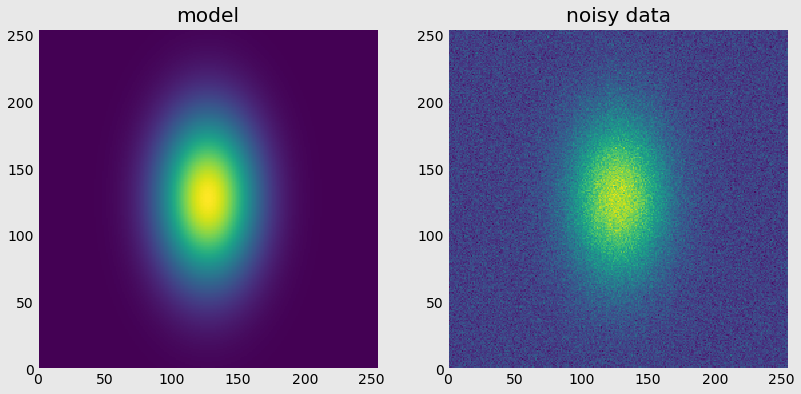

In [13]:
# create the 1D list (xy_mesh) of 2D arrays of (x,y) coords
x = np.arange(256)
y = np.arange(256)
xy_mesh = np.meshgrid(x,y)

# set initial parameters to build mock data
amp = 1
xc, yc = np.median(x), np.median(y)
sigma_x, sigma_y = x[-1]/10, y[-1]/6

noise_factor = 0.07

# make both clean and noisy data, reshaping the Gaussian to proper 2D dimensions
data = gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y).reshape(np.outer(x, y).shape)
noise = data + noise_factor*data.max()*np.random.normal(size=data.shape)

# plot the function and with noise added
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(data, origin='bottom')
plt.grid(visible=False)
plt.subplot(1,2,2)
plt.title('noisy data')
plt.imshow(noise, origin='bottom')
plt.grid(visible=False)
plt.show()

Let's then take this noisy data, and apply the `curve_fit()` routine. This part looks a lot like the 1D case! Just notice the `np.ravel()` in the call to `curve_fit()`.

In [14]:
# define some initial guess values for the fit routine
guess_vals = [amp*2, xc*0.8, yc*0.8, sigma_x/1.5, sigma_y/1.5]

# perform the fit, making sure to flatten the noisy data for the fit routine 
fit_params, cov_mat = curve_fit(gaussian_2d, xy_mesh, np.ravel(noise), p0=guess_vals)

# calculate fit parameter errors from covariance matrix
fit_errors = np.sqrt(np.diag(cov_mat))

# manually calculate R-squared goodness of fit
fit_residual = noise - gaussian_2d(xy_mesh, *fit_params).reshape(np.outer(x,y).shape)
fit_Rsquared = 1 - np.var(fit_residual)/np.var(noise)

print('Fit R-squared:', fit_Rsquared, '\n')
print('Fit Amplitude:', fit_params[0], '\u00b1', fit_errors[0])
print('Fit X-Center: ', fit_params[1], '\u00b1', fit_errors[1])
print('Fit Y-Center: ', fit_params[2], '\u00b1', fit_errors[2])
print('Fit X-Sigma:  ', fit_params[3], '\u00b1', fit_errors[3])
print('Fit Y-Sigma:  ', fit_params[4], '\u00b1', fit_errors[4])

Fit R-squared: 0.893643627153 

Fit Amplitude: 0.99950676338 ± 0.00169671033676
Fit X-Center:  127.527350493 ± 0.0432660004695
Fit Y-Center:  127.49298452 ± 0.0720998265062
Fit X-Sigma:   25.5017399657 ± 0.0432660012603
Fit Y-Sigma:   42.4886532131 ± 0.072220369238


In [15]:
# check against actual parameter values
amp, xc, yc, sigma_x, sigma_y

(1, 127.5, 127.5, 25.5, 42.5)

If we are simply interested in showing the standard deviations **from** the mean, we'll need to plot the waist contours, $1\sigma$, $2\sigma$, $3\sigma$, etc. This just shows the probability coverage of our function and doesn't take advantage of the fitting we've just done, but it does allow us to show how to create contours on a 2D plot, which we'll need for the next part.

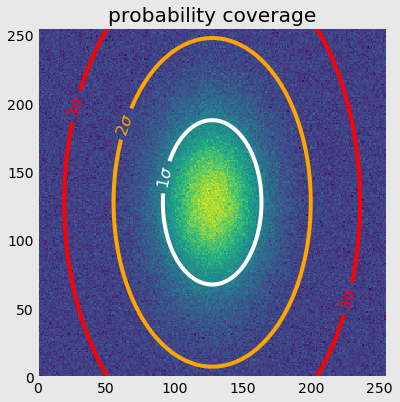

In [16]:
# set contour levels out to 3 sigma
sigma_x_pts = xc + [sigma_x, 2*sigma_x, 3*sigma_x]
sigma_y_pts = yc + [sigma_y, 2*sigma_y, 3*sigma_y]
sigma_xy_mesh = np.meshgrid(sigma_x_pts, sigma_y_pts)

contour_levels = gaussian_2d(sigma_xy_mesh, amp, xc, yc, 
                             sigma_x, sigma_y).reshape(sigma_xy_mesh[0].shape)
contour_levels = list(np.diag(contour_levels)[::-1])

# make labels for each contour
labels = {}
label_txt = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$']
for level, label in zip(contour_levels, label_txt):
    labels[level] = label

# plot the function with noise added
plt.figure(figsize=(6,6))
plt.title('probability coverage')
plt.imshow(noise, origin='lower')
CS = plt.contour(data, levels=contour_levels, colors=['red', 'orange', 'white'])
plt.clabel(CS, fontsize=16, inline=1, fmt=labels)
plt.grid(visible=False)
plt.show()

Now, let's actually display the standard deviation **in** the mean, as a result of our fitting procedure. The error here was quite small (~0.03%), which means less than a pixel in diameter in the image above. We'll have to rescale this image to zoom in for a view of the fit uncertainty on the center.

In [17]:
# create a zoomed view of the noisy data, using fit error for scaling
x_zoom = np.linspace(xc-7*fit_errors[1], xc+7*fit_errors[1], 256)
y_zoom = np.linspace(xc-5*fit_errors[2], xc+5*fit_errors[2], 256)
xy_mesh_zoom = np.meshgrid(x_zoom,y_zoom)

# make noisy data using same parameters as before, except zoomed to center
data_zoom = gaussian_2d(xy_mesh_zoom, amp, xc, yc, 
                        sigma_x, sigma_y).reshape(np.outer(x_zoom,y_zoom).shape)
noise_zoom = data_zoom + noise_factor*data_zoom.max()*np.random.normal(size=data_zoom.shape)

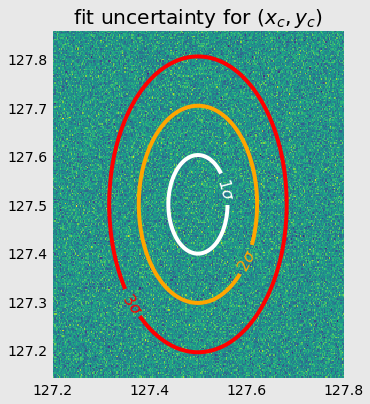

In [18]:
# set contour levels out to 3 standard deviations
err_x_pts = xc + [fit_errors[1], 2*fit_errors[1], 3*fit_errors[1]]
err_y_pts = yc + [fit_errors[2], 2*fit_errors[2], 3*fit_errors[2]]
err_xy_mesh = np.meshgrid(err_x_pts, err_y_pts)

extent = [x_zoom[0], x_zoom[-1], y_zoom[0], y_zoom[-1]]

contour_levels = gaussian_2d(err_xy_mesh, amp, xc, yc, 
                             sigma_x, sigma_y).reshape(err_xy_mesh[0].shape)
contour_levels = list(np.diag(contour_levels)[::-1])

# make labels for each contour
labels = {}
label_txt = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$']
for level, label in zip(contour_levels, label_txt):
    labels[level] = label

# plot the function with noise added
plt.figure(figsize=(6,6))
plt.title('fit uncertainty for $(x_c, y_c)$')
plt.imshow(noise_zoom, origin='lower', extent=extent)
CS = plt.contour(data_zoom, levels=contour_levels, origin='lower',
                 colors=['red', 'orange', 'white'], extent=extent)
plt.clabel(CS, fontsize=16, inline=1, fmt=labels)
plt.grid(visible=False)
plt.show()

Wow.. we've narrowed the position of the distribution peak down so much that there's hardly any variation in the data on this scale. This just goes to show: an excellent fit result starts with excellent data (*and* a correct choice of analytical model).

## Method 2: using the LMFIT package

Again, LMFIT is extraordinarily easy to use. All is exactly the same as for the 1D case, only with the `np.ravel()`. In each of these cases, the major changes we're making is to the fit function itself so that flattened data can be compared to a flattened model.

In [19]:
# tell LMFIT what fn you want to fit, then fit, starting iteration with guess values
lmfit_model = Model(gaussian_2d)
lmfit_result = lmfit_model.fit(np.ravel(noise), 
                               xy_mesh=xy_mesh, 
                               amp=guess_vals[0], 
                               xc=guess_vals[1], 
                               yc=guess_vals[2], 
                               sigma_x=guess_vals[3], 
                               sigma_y=guess_vals[4])

# again, calculate R-squared
lmfit_Rsquared = 1 - lmfit_result.residual.var()/np.var(noise)

print('Fit R-squared:', lmfit_Rsquared, '\n')
print(lmfit_result.fit_report())

Fit R-squared: 0.893643627153 

[[Model]]
    Model(gaussian_2d)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 65536
    # variables        = 5
    chi-square         = 6.9196e-06
    reduced chi-square = 1.0559e-10
    Akaike info crit   = -1505450.78
    Bayesian info crit = -1505405.33
[[Variables]]
    amp:      0.99950676 +/- 0.00169671 (0.17%) (init = 2)
    xc:       127.527350 +/- 0.04326600 (0.03%) (init = 102)
    yc:       127.492985 +/- 0.07209983 (0.06%) (init = 102)
    sigma_x:  25.5017400 +/- 0.04326600 (0.17%) (init = 17)
    sigma_y:  42.4886532 +/- 0.07222037 (0.17%) (init = 28.33333)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma_y) =  0.501
    C(amp, sigma_x) =  0.500



In [20]:
lmfit_result.params.pretty_print()

Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp        0.9995     -inf      inf 0.001697     True     None     None
sigma_x      25.5     -inf      inf  0.04327     True     None     None
sigma_y     42.49     -inf      inf  0.07222     True     None     None
xc          127.5     -inf      inf  0.04327     True     None     None
yc          127.5     -inf      inf   0.0721     True     None     None


In [21]:
# check against actual parameter values
amp, xc, yc, sigma_x, sigma_y

(1, 127.5, 127.5, 25.5, 42.5)

# Fitting in *N*D...
As you can see, the entire trick hinges on this:  
    1. create your multidimensional fitting function, but flatten the output to 1D;  
    2. flatten your multidimensional data to 1D;  
    3. employ the fit routine as you would normally for the 1D case, given the package you're working with.  
    
With this as your algorithm, you can scale the 2D procudure outlined above in a fairly straightforward manner. It *would* be interesting to see the limits of this proceedure, though. I know the folks over at Big Data have some slick tricks for doing things like this. I'm just curious how much of it essentially comes down to applying these same procedures after taking an out-of-memory data set and applying principle component analysis on it as a sub-selection step.

IN any case, there it is... Not too terribly difficult after all. As long as you have correctly chosen your model and are able to faithfully code it up, you should now be able to quantify how well measured reality matches mathematical expectation.  

# References
+ The above code is also available as a [Jupyter Notebook on my github](https://github.com/kippvs/nonlinear-least-squares-fitting)
+ [The Jupyter Project website](http://jupyter.org/)
+ [The Numpy package website](http://www.numpy.org/)
+ [The Scipy package website](https://www.scipy.org/) and [scipy.optimize documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
+ [The Matplotlib package website](https://matplotlib.org/)
+ [The LMFIT package website](https://lmfit.github.io/lmfit-py/)